### SVM Model with PCA

In [1]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.inspection import permutation_importance
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import shap

# Load data
df_train = pd.read_parquet('train_df.parquet', engine='pyarrow')
df_test = pd.read_parquet('test_df.parquet', engine='pyarrow')

X_train = df_train.drop(
    ["is_anomalous", "_ANOMALY_TYPES_DROP_BEFORE_TRAINING_"], axis=1, errors="ignore"
)
y_train = df_train["is_anomalous"]
X_test = df_test.drop(
    ["is_anomalous", "_ANOMALY_TYPES_DROP_BEFORE_TRAINING_"], axis=1, errors="ignore"
)
y_test = df_test["is_anomalous"]
# Identify categorical columns and label-encode them
col_types = dict(X_train.dtypes)
label_cols = [col for col, dtype in col_types.items() if dtype == 'object']

encoders = {}
for col in label_cols:
    encoder = LabelEncoder()
    combined = pd.concat([X_train[col], X_test[col]], axis=0).astype(str)
    encoder.fit(combined)
    X_train[col] = encoder.transform(X_train[col].astype(str))
    X_test[col] = encoder.transform(X_test[col].astype(str))
    encoders[col] = encoder

# drop date columns
X_train = X_train.drop(columns=['invoice_date', 'due_date'])
X_test = X_test.drop(columns=['invoice_date', 'due_date'])

# standardize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# dimensionality reduction
pca = PCA(n_components=10, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Train an SVM with RBF Kernel on the PCA features
model = SVC(kernel='rbf',
            C=1.0,
            gamma='scale',
            class_weight='balanced',
            probability=True,
            random_state=42)

model.fit(X_train_pca, y_train)

y_pred = model.predict(X_test_pca)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9800759013282733

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98      1198
           1       0.99      0.96      0.98       910

    accuracy                           0.98      2108
   macro avg       0.98      0.98      0.98      2108
weighted avg       0.98      0.98      0.98      2108



### without merchant info

In [2]:
X_train = X_train.drop(columns=['merchant', 'merchant_branch', 'merchant_chain', 'merchant_address'])
X_test = X_test.drop(columns=['merchant', 'merchant_branch', 'merchant_chain', 'merchant_address'])

# Identify categorical columns
col_types = dict(X_train.dtypes)
label_cols = [col for col, dtype in col_types.items() if dtype == 'object']

# Label encode each categorical column (keeping consistency between train and test)
encoders = {}
for col in label_cols:
    encoder = LabelEncoder()
    combined = pd.concat([X_train[col], X_test[col]], axis=0).astype(str)
    encoder.fit(combined)
    X_train[col] = encoder.transform(X_train[col].astype(str))
    X_test[col] = encoder.transform(X_test[col].astype(str))
    encoders[col] = encoder  # Optional: store encoders for inverse_transform or future use
    
# standardize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# dimensionality reduction
pca = PCA(n_components=10, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Train an SVM with RBF Kernel on the PCA features
model = SVC(kernel='rbf',
            C=1.0,
            gamma='scale',
            class_weight='balanced',
            probability=True,
            random_state=42)

model.fit(X_train_pca, y_train)

y_pred = model.predict(X_test_pca)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9838709677419355

Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      1198
           1       1.00      0.97      0.98       910

    accuracy                           0.98      2108
   macro avg       0.99      0.98      0.98      2108
weighted avg       0.98      0.98      0.98      2108



### Threshold adjustment for better recall results

In [3]:
y_proba = model.predict_proba(X_test_pca)[:, 1]
y_pred_thresh = (y_proba >= 0.35).astype(int)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred_thresh))

Accuracy: 0.9838709677419355
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      1198
           1       0.94      0.97      0.96       910

    accuracy                           0.96      2108
   macro avg       0.96      0.96      0.96      2108
weighted avg       0.96      0.96      0.96      2108



### Adding feature importance graph

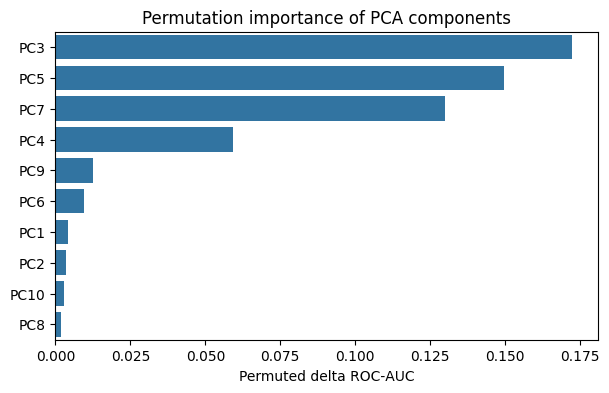

In [4]:
# use permutation importance for non-linear SVM
perm = permutation_importance(
    model,                 
    X_test_pca,             
    y_test,
    n_repeats=30,
    scoring="roc_auc",
    random_state=42,
)

pca_imp = (
    pd.DataFrame(
        {"component": [f"PC{i+1}" for i in range(pca.n_components_)],
         "importance": perm.importances_mean}
    )
    .sort_values("importance", ascending=False)
)

plt.figure(figsize=(7, 4))
sns.barplot(data=pca_imp, x="importance", y="component", orient="h")
plt.title("Permutation importance of PCA components")
plt.xlabel("Permuted delta ROC‑AUC")
plt.ylabel("")
plt.show()

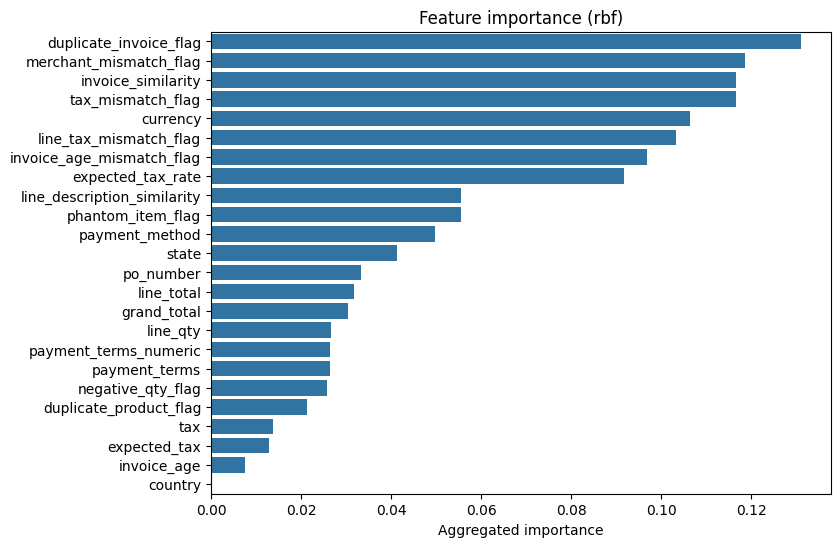

In [5]:
# Map component importance back to raw features
loadings = np.abs(pca.components_)        # (k × p)
comp_weights = pca_imp.set_index("component").loc[
    [f"PC{i+1}" for i in range(pca.n_components_)]
]["importance"].values                    # (k,)

# calculate raw scores
raw_scores = loadings.T @ comp_weights    # (p,)

feat_imp = (
    pd.DataFrame({"feature": X_train.columns, "importance": raw_scores})
    .sort_values("importance", ascending=False)
)

plt.figure(figsize=(8, 6))
sns.barplot(
    data=feat_imp, 
    x="importance",
    y="feature",
    orient="h"
)
plt.title("Feature importance (rbf)")
plt.xlabel("Aggregated importance")
plt.ylabel("")
plt.show()

### ROC curve

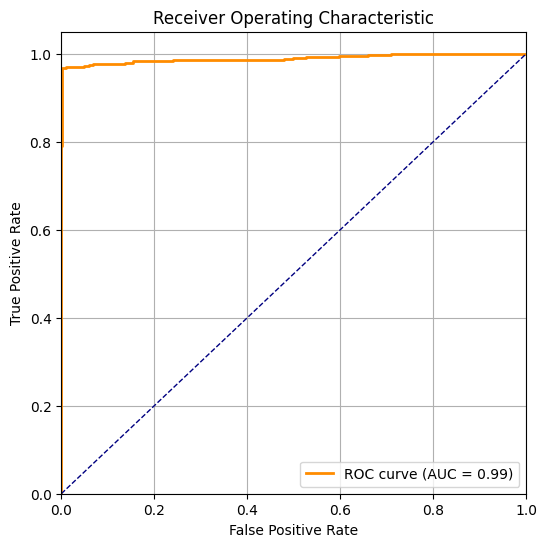

In [6]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.grid()
plt.show()

### SHAP Plot

  0%|          | 0/100 [00:00<?, ?it/s]

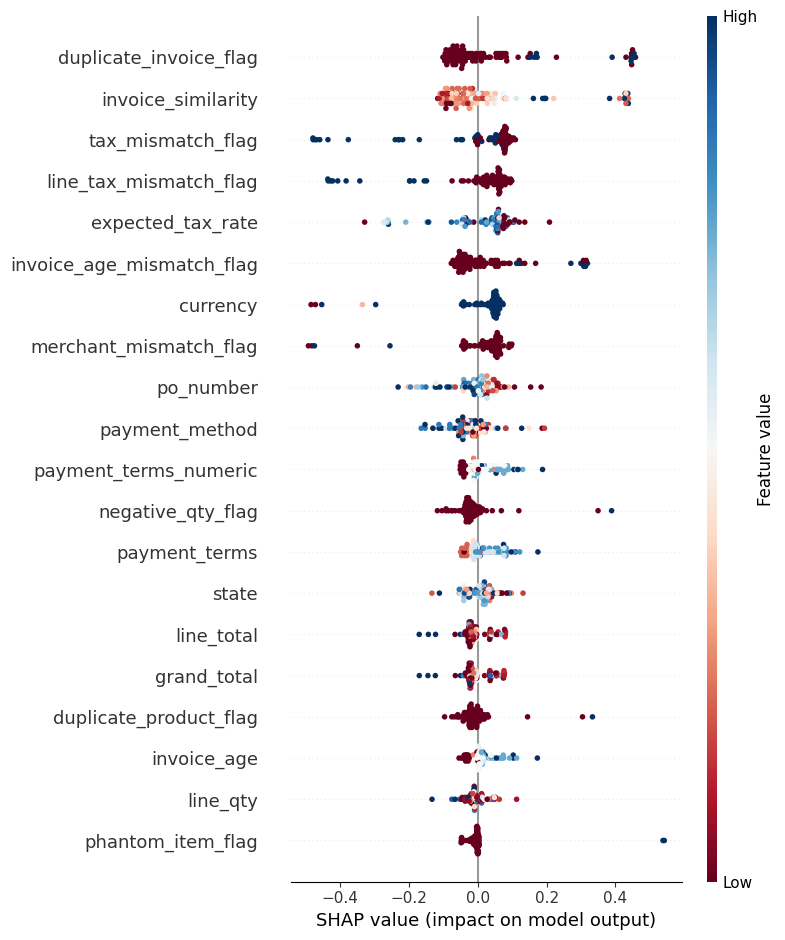

In [7]:
f_pred = lambda x: model.predict(x)

explainer = shap.KernelExplainer(f_pred, X_train_pca[:100])

shap_vals = explainer.shap_values(X_test_pca[:100])

# map back to raw features
shap_raw = np.dot(shap_vals, pca.components_)  # (100,10) @ (10,24) → (100,24)

shap.summary_plot(shap_raw,
                  X_test.iloc[:100],
                  feature_names=X_test.columns,
                  plot_type="dot",
                  cmap="RdBu",
                  color_bar=True)